<a href="https://colab.research.google.com/github/Yztai36/Bitecheck/blob/main/bitecheck_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Gemini API anahtarı başarıyla yüklendi ve yapılandırıldı.
Gemini 1.5 Flash modeli hazır.
'bitecheck_best.pt' özel PyTorch modeli başarıyla yüklendi (weights_only=False ile).
Özel model sınıf isimleri: ['ants', 'bed_bugs', 'bee', 'chigger', 'fleas', 'mosquitos', 'no_bites', 'spider', 'ticks']

--- Test Başlıyor ---

Lütfen analiz etmek istediğiniz bir görseli yükleyin (örn: bir böcek ısırığı fotoğrafı):


Saving Ekran görüntüsü 2025-07-18 100422.png to Ekran görüntüsü 2025-07-18 100422 (1).png
'Ekran görüntüsü 2025-07-18 100422 (1).png' isimli görsel yüklendi.

Yüklenen görsel (Orijinal):


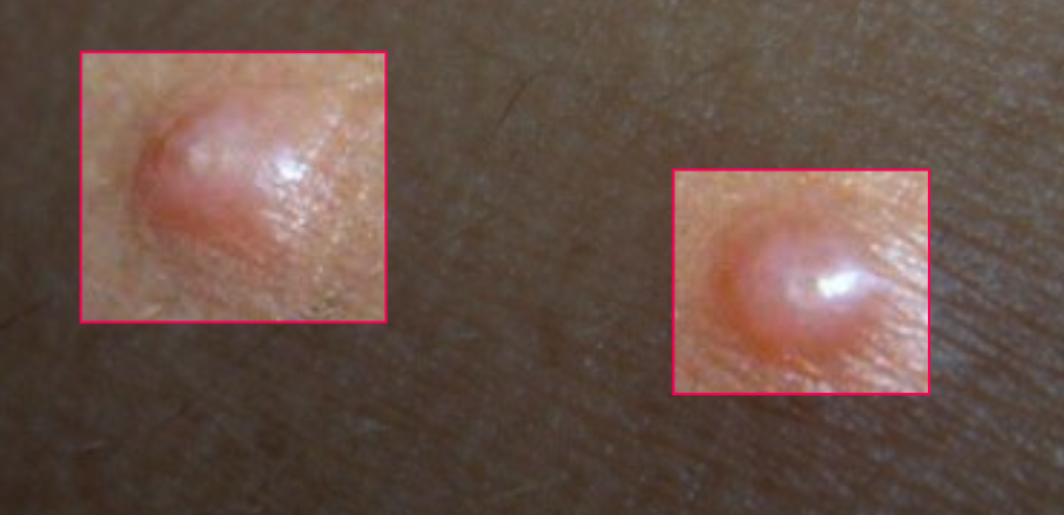

Gürültü azaltma uygulanıyor (Median Blur).
Görsel 1064x515 boyutundan 224x224 boyutuna getiriliyor.
Gemini için PIL Image hazırlandı.
PyTorch modeli için Tensor hazırlandı.

--- Gemini ile detaylı analiz yapılıyor... ---

🤖 Gemini Analiz Sonuçları ve Öneriler:
Resimdeki iki lezyonun değerlendirilmesi aşağıdadır:

**1. Görseldeki Belirgin Bulgular ve Özellikler:**

* **Kızarıklık ve Şişlik:** Her iki lezyonda da hafif bir kızarıklık ve şişlik gözlemlenmektedir.
* **Kabarcıklar:**  Her iki lezyon da küçük ve hafif kabarık görünümlü olup, içi sıvı dolu bir kabarcık izlenimi vermektedir.
* **İrin:** Görüntüde irin belirtisi yoktur.
* **Merkezdeki Nokta:** Merkezde koyu bir nokta veya nekroz belirtisi gözlemlenmemektedir.
* **Yara İzi:**  Yara izi mevcut değildir.
* **Renk Değişiklikleri:**  Önemli bir renk değişikliği (morarma, solukluk) görülmemektedir.
* **Boyut ve Şekil:**  Lezyonlar küçük, yaklaşık 3-5 mm çapındadır ve yuvarlak görünmektedir.
* **Görüntü Kalitesi:** Görüntü kalitesi ma

In [10]:

#!pip install torch torchvision torchaudio
#!pip install google-generativeai Pillow opencv-python-headless python-dotenv

# --- Kütüphaneleri İçe Aktar ---
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
import os
from io import BytesIO
import google.generativeai as genai

# Colab'da görüntü göstermek için gerekli
from google.colab.patches import cv2_imshow
import cv2 # OpenCV kullanımı için
from google.colab import files # Dosya yüklemek için
from google.colab import userdata # Colab Secrets'tan API key almak için

# --- API Anahtarlarını ve Gemini Modelini Yapılandırma ---
# Colab Secrets'tan API anahtarını güvenli bir şekilde al
try:
    GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
    os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY # Ortam değişkeni olarak ayarla
    genai.configure(api_key=GEMINI_API_KEY)
    print("Gemini API anahtarı başarıyla yüklendi ve yapılandırıldı.")
except Exception as e:
    print(f"🚨 Hata: Gemini API anahtarı yüklenirken veya yapılandırılırken sorun oluştu: {e}.")
    print("Lütfen Colab Secrets'ı kontrol edin ve 'GOOGLE_API_KEY' sırrının doğru ayarlandığından emin olun.")

# Gemini Vision Pro modelini başlat
gemini_model = genai.GenerativeModel('gemini-1.5-flash') # <-- BU SATIR GÜNCELLENDİ
print("Gemini 1.5 Flash modeli hazır.")

# --- PyTorch Modelini Yükle ve Hazırla ---
# Cihaz ayarı (Colab'da GPU varsa 'cuda', yoksa 'cpu' kullanır)
device = "cuda" if torch.cuda.is_available() else "cpu"

custom_image_classifier = None
MODEL_PATH = "bitecheck_best.pt" # Arkadaşının kaydettiği model dosyası adı

# MODEL DOSYASINI BURAYA YÜKLEDİĞİNİZDEN EMİN OLUN!
# Sol paneldeki dosya simgesine tıklayıp dosyayı sürükle-bırak yaparak yükleyebilirsiniz.
try:
    # torch.load fonksiyonuna weights_only=False argümanını ekliyoruz
    custom_image_classifier = torch.load(MODEL_PATH, map_location=device, weights_only=False)
    custom_image_classifier.eval() # Modeli çıkarım moduna al
    print(f"'{MODEL_PATH}' özel PyTorch modeli başarıyla yüklendi (weights_only=False ile).")
except FileNotFoundError:
    print(f"⚠️ Uyarı: Özel PyTorch modeli bulunamadı: '{MODEL_PATH}'. Sadece Gemini analizi yapılacak.")
except Exception as e:
    print(f"🚨 Hata: Özel PyTorch modeli yüklenirken başka bir hata oluştu: {e}. Sadece Gemini analizi yapılacak.")
# Sınıf isimlerini, arkadaşınızın eğitim kodundan (class_names çıktısı) alın!
# BURADAKİ SIRALAMA ÇOK ÇOK ÖNEMLİDİR!
# Arkadaşınızın kodunda `print("Sınıflar:", class_names)` satırının çıktısını buraya kopyalayın.
# Örnek: ['KeneIsirigi', 'SivrisinekIsirigi', 'NormalCilt']
CLASS_NAMES_CUSTOM_MODEL = ['ants', 'bed_bugs', 'bee', 'chigger', 'fleas', 'mosquitos', 'no_bites', 'spider', 'ticks']
print("Özel model sınıf isimleri:", CLASS_NAMES_CUSTOM_MODEL)


# Model için dönüştürme (transform) pipeline'ı
# Bu, arkadaşınızın eğitimde kullandığı ile AYNI olmalı (224x224 resize, ToTensor)
model_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor() # Bu otomatik olarak 0-1 arasına normalize eder
])

# --- Görüntü Ön İşleme Fonksiyonu ---
def preprocess_image_for_all_models(image_pil, target_size=(224, 224), apply_denoising=False):
    """
    PIL Image'ı hem Gemini hem de özel PyTorch model için hazırlar.
    Args:
        image_pil (PIL.Image.Image): Ön işlenecek PIL Image objesi.
        target_size (tuple): Görselin yeniden boyutlandırılacağı (genişlik, yükseklik).
        apply_denoising (bool): Gürültü azaltma uygulanıp uygulanmayacağı.
    Returns:
        tuple: (Gemini için hazırlanmış PIL Image, PyTorch modeli için hazırlanmış Tensor)
    """
    # 1. PIL Image'ı NumPy dizisine dönüştür (RGB formatında gelir)
    img_np_rgb = np.array(image_pil)

    # 2. RGB'den BGR'ye dönüştür (OpenCV işlemleri genellikle BGR bekler)
    img_cv_bgr = cv2.cvtColor(img_np_rgb, cv2.COLOR_RGB2BGR)

    # 3. İsteğe bağlı olarak gürültü azaltma uygula
    if apply_denoising:
        print("Gürültü azaltma uygulanıyor (Median Blur).")
        img_cv_bgr = cv2.medianBlur(img_cv_bgr, 5) # Kernel boyutu tek sayı olmalı

    # 4. Modellerin beklediği boyuta yeniden boyutlandır (OpenCV kullanarak)
    print(f"Görsel {img_cv_bgr.shape[1]}x{img_cv_bgr.shape[0]} boyutundan {target_size[0]}x{target_size[1]} boyutuna getiriliyor.")
    img_resized_bgr = cv2.resize(img_cv_bgr, target_size, interpolation=cv2.INTER_AREA)

    # --- Çıktılar ---
    # a) Gemini için: Tekrar PIL Image'a dönüştür (Gemini doğrudan PIL Image kabul eder)
    # OpenCV'den gelen BGR'yi tekrar RGB'ye çevirip PIL'e veriyoruz
    img_for_gemini_pil = Image.fromarray(cv2.cvtColor(img_resized_bgr, cv2.COLOR_BGR2RGB))
    print("Gemini için PIL Image hazırlandı.")

    # b) PyTorch modeli için: PyTorch transformunu uygula ve unsqueeze ile batch boyutu ekle
    # PyTorch transform'u PIL Image veya NumPy array (HWC) bekler.
    # img_for_gemini_pil'i kullanarak dönüştürüyoruz
    img_for_pytorch_tensor = model_transform(img_for_gemini_pil).unsqueeze(0).to(device)
    print("PyTorch modeli için Tensor hazırlandı.")

    return img_for_gemini_pil, img_for_pytorch_tensor

# --- Gemini Analiz Fonksiyonu ---
def analyze_with_gemini(image_pil_processed):
    """
    Yüklenen görseli Gemini Pro Vision modeli ile analiz eder ve detaylı öneriler sunar.
    Args:
        image_pil_processed (PIL.Image.Image): Analiz edilecek PIL Image objesi.
    Returns:
        str: Gemini'den gelen analiz sonuçları ve önerileri içeren metin.
    """
    prompt = """
    Bu bir böcek ısırığı veya cilt lezyonu fotoğrafı. Lütfen görseldeki belirtileri dikkatlice inceleyerek aşağıdaki bilgileri detaylı bir şekilde değerlendirerek sağlayın:

    1.  **Görseldeki Belirgin Bulgular ve Özellikler:**
        * Kızarıklık, şişlik, kabarcıklar, irin, merkezdeki bir nokta (siyah nokta gibi), yara izleri, renk değişiklikleri (morarma, solukluk) veya herhangi bir anormal doku gibi gözle görülebilir tüm özellikleri tanımlayın.
        * Isırığın boyutu ve şekli hakkında bir yorum yapın (varsa).
        * Görüntü kalitesi, aydınlatma veya netlik gibi faktörlerin analizi nasıl etkilediği hakkında bir not düşebilir misiniz?

    2.  **Böcek Isırığı Türü Olasılığı:**
        * Görseldeki belirtilere dayanarak, bu ısırık bir **kene ısırığına** benziyor mu? Eğer kene görülebiliyorsa, konumunu ve türünü (eğer tanınabiliyorsa) belirtin.
        * Eğer kene ısırığına benzemiyorsa, bir **sivrisinek ısırığına, örümcek ısırığına, karınca ısırığına, pire ısırığına, arı/eşek arısı sokmasına** veya **başka bir yaygın böcek ısırığına** benziyor olabilir mi? Lütfen kesin teşhis koymaktan kaçının, sadece olasılıkları veya benzerlikleri ifade edin. Görüntüde birden fazla olası ısırık varsa bunları da değerlendirin.


    3.  **Acil Tıbbi Durum İşaretleri:**
        * Görüntüde **şiddetli enfeksiyon (örn. irinli akıntı, sıcaklık hissi, ısırığın etrafında hızla yayılan kızarıklık, kırmızı çizgiler)**,
        * **Genel veya şiddetli alerjik reaksiyon (örn. ısırık bölgesinin ötesinde şişlik, kurdeşen, nefes darlığı, yutma güçlüğü)**,
        * **Sistemik belirtiler (örn. ateş, titreme, baş ağrısı, kas ağrısı, halsizlik)**
        * gibi acil tıbbi müdahale gerektirebilecek herhangi bir işaret veya endişe verici bulgu var mı?

    4.  **Evde Uygulanabilecek İlk Yardım/Müdahale Önerileri:**
        * Tanımlanan belirtilere göre, evde güvenle uygulanabilecek ilk yardım veya bakım önerileri sunun. Örneğin: alanı sabun ve suyla nazikçe temizleme, soğuk kompres uygulama, kaşıntı/şişlik giderici kremler (hidrokortizon, kalamin losyonu) kullanma, ısırılan bölgeyi yüksekte tutma, bölgeyi kaşımaktan kaçınma.
        * Kene ısırığı şüphesinde, kenenin doğru bir şekilde nasıl çıkarılacağına dair kısa ve anlaşılır adımlar belirtin (cımbızla cilde en yakın yerden nazikçe çekme).

    5.  **Ne Zaman Bir Sağlık Uzmanına Danışılmalı?**
        * Isırık belirtilerinin kötüleşmesi (boyut olarak büyüme, artan ağrı, daha fazla şişlik),
        * İyileşmemesi veya beklenenden daha uzun sürmesi,
        * Yukarıda belirtilen enfeksiyon veya alerjik reaksiyon belirtilerinin ortaya çıkması,
        * Kene ısırığı sonrası grip benzeri belirtiler (ateş, baş ağrısı, vücut ağrısı) veya ısırık etrafında "hedef tahtası" şeklinde kızarıklık (Lyme hastalığı belirtisi olabilir) görülmesi durumunda ne zaman bir doktora veya sağlık profesyoneline başvurulması gerektiğini açıkça açıklayın.

    Lütfen yanıtınızı net, anlaşılır, profesyonel bir tonda ve madde madde olacak şekilde yapılandırın. Teşhis koymaktan kesinlikle kaçının, sadece bilgi ve rehberlik sağlayın.
    """

    try:
        response = gemini_model.generate_content([prompt, image_pil_processed])
        return response.text
    except Exception as e:
        return f"Gemini analizi sırasında bir hata oluştu: {e}. Lütfen internet bağlantınızı ve API anahtarınızın doğru çalıştığını kontrol edin. Ayrıca yüklediğiniz görselin geçerli bir resim dosyası olduğundan emin olun."

# --- Test Kısımı: Bir Görsel Yükle ve Analiz Et ---
print("\n--- Test Başlıyor ---")

# Colab'a test görseli yüklemesini sağlayalım
print("\nLütfen analiz etmek istediğiniz bir görseli yükleyin (örn: bir böcek ısırığı fotoğrafı):")
uploaded = files.upload()

if uploaded:
    # Yüklenen görsellerin listesinden ilkini al
    image_name = list(uploaded.keys())[0]
    print(f"'{image_name}' isimli görsel yüklendi.")

    # Yüklenen dosya içeriğini PIL Image objesine dönüştür
    original_image_pil = Image.open(BytesIO(uploaded[image_name]))

    print("\nYüklenen görsel (Orijinal):")
    display(original_image_pil) # Colab'da PIL Image'ı doğrudan göstermek için

    # Görüntüyü hem Gemini hem de özel model için hazırla
    # apply_denoising=True ile gürültü azaltma uygulayabilirsin
    processed_image_for_gemini, img_for_pytorch_tensor = preprocess_image_for_all_models(original_image_pil, apply_denoising=True)

    # --- Gemini Analizi ---
    print("\n--- Gemini ile detaylı analiz yapılıyor... ---")
    gemini_result = analyze_with_gemini(processed_image_for_gemini)
    print("\n🤖 Gemini Analiz Sonuçları ve Öneriler:")
    print(gemini_result)
    print("------------------------------------------")

    # --- Özel PyTorch Model Tahmini ---
    if custom_image_classifier is not None:
        print("\n✨ Özel Görüntü Sınıflandırma Modeli Tahmini yapılıyor... ---")
        try:
            with torch.no_grad(): # Çıkarım sırasında gradyan hesaplamayı kapat
                output = custom_image_classifier(img_for_pytorch_tensor)
                # Çıktıları olasılıklara dönüştür (softmax)
                probabilities = torch.nn.functional.softmax(output, dim=1)[0]

                # En yüksek olasılığa sahip sınıfı ve olasılık değerini bul
                predicted_prob, predicted_idx = torch.max(probabilities, 0)
                predicted_class_name = CLASS_NAMES_CUSTOM_MODEL[predicted_idx.item()]
                confidence = predicted_prob.item() * 100

            print(f"Modelin tahmini: **{predicted_class_name}** (Güven: **%{confidence:.2f}**)")

            # Güven eşiği kontrolü
            if confidence < 70: # Güven eşiğini buradan ayarlayabilirsin
                print("⚠️ Modelin bu tahmini için güven oranı düşük. Daha fazla bilgi edinmek ve doğru teşhis için lütfen Gemini analizine ve bir sağlık uzmanına danışın.")

        except Exception as e:
            print(f"🚨 Hata: Özel model tahmini sırasında bir hata oluştu: {e}")
            print("Lütfen model dosyasının doğru yüklendiğinden ve sınıf isimleri listesinin doğru olduğundan emin olun.")
    else:
        print("Özel model yüklenemediği için özel model tahmini yapılamadı.")

else:
    print("Analiz edilecek bir görsel bulunamadı. Lütfen bir görsel yükleyerek devam edin.")

print("\n--- Test Tamamlandı ---")